<a href="https://colab.research.google.com/github/chacha715/ESAA_OB/blob/main/OB1%EC%A1%B0_0331_EDA_%EC%B6%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 물류 유통량 예측 경진대회

https://dacon.io/competitions/official/235867/overview/description

* 목적
: 제주시 내 택배 운송 데이터를 이용하여 운송량 예측 AI 개발

* 데이터 정보
  - train_df.csv

    - index : 인덱스
    - 송하인_격자공간고유번호
    - 수하인 격자공간고유번호
    - 물품_카테고리
    - 운송장_건수
  - test_df.csv
    - index : 인덱스
    - 송하인_격자공간고유번호
    - 수하인 격자공간고유번호
    - 물품_카테고리
  - sample_submission.csv
    - index : 인덱스
    - 운송장_건수





# 01 라이브러리 및 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

import warnings
warnings.filterwarnings(action='ignore')

In [14]:
import os
os.chdir("/content/drive/MyDrive/OB1조/프로젝트(1)/Data/") # working directory를 설정함

In [5]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

submission = pd.read_csv('sample_submission.csv')

In [6]:
train.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
index,,,,
0,5011000595017300,2871000192069300,음반,3
1,4148000690043300,5011000264024400,문화컨텐츠,3
2,5011000078068400,1120000007005400,농산물,3
3,4127100048006400,5011000587019400,기타식품,7
4,5011000078068400,2823700010076300,농산물,3


In [7]:
test.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리
index,,,
0,4167000577042200,5011000435014100,선케어
1,1156000009012200,5011000172034400,구강위생용품
2,4122000363057300,5011000361097300,캠핑
3,5011000436041400,2826000084036400,아웃도어가구
4,4150000241065200,5011000169044300,분유/이유식/아기간식


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31684 entries, 0 to 31683
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   송하인_격자공간고유번호  31684 non-null  int64 
 1   수하인_격자공간고유번호  31684 non-null  int64 
 2   물품_카테고리       31684 non-null  object
 3   운송장_건수        31684 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ MB


- null 데이터 없이 잘 들어가 있음을 알 수 있다. 

In [9]:
train.isnull().sum()

송하인_격자공간고유번호    0
수하인_격자공간고유번호    0
물품_카테고리         0
운송장_건수          0
dtype: int64

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   송하인_격자공간고유번호  7920 non-null   int64 
 1   수하인_격자공간고유번호  7920 non-null   int64 
 2   물품_카테고리       7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 247.5+ KB


- null 데이터 없이 잘 들어가 있음을 알 수 있다. 

# 02 데이터 해석


## 1) 격자공간고유번호 의미

*   의미단위별로 분리   
 *   시: 1-2번째 숫자
 *   군/구: 3-5번째 숫자
 *   동: 6-10번째 숫자

In [15]:
seoul = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_11.csv') # index_col=0
seoul.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,1150000001001100,다사3855,11500,강서구
1,1150000001001200,다사3855,11500,강서구
2,1150000001001300,다사3855,11500,강서구
3,1150000001001400,다사3855,11500,강서구
4,1150000001002100,다사3855,11500,강서구


In [16]:
seoul[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
강남구,11680
강동구,11740
강북구,11305
강서구,11500
관악구,11620
광진구,11215
구로구,11530
금천구,11545
노원구,11350


In [17]:
busan = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_26.csv') # index_col=0
busan.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,2644000001001100,마라3493,26440,강서구
1,2644000001001200,마라3493,26440,강서구
2,2644000001001300,마라3493,26440,강서구
3,2644000001001400,마라3493,26440,강서구
4,2644000001002100,마라3493,26440,강서구


In [18]:
busan[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
강서구,26440
금정구,26410
기장군,26710
남구,26290
동구,26170
동래구,26260
부산진구,26230
북구,26320
사상구,26530


In [19]:
daegu = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_27.csv') # index_col=0
daegu.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,2771000001001100,라마8671,27710,달성군
1,2771000001001200,라마8671,27710,달성군
2,2771000001001300,라마8671,27710,달성군
3,2771000001001400,라마8671,27710,달성군
4,2771000001002100,라마8671,27710,달성군


In [20]:
daegu[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
남구,27200
달서구,27290
달성군,27710
동구,27140
북구,27230
서구,27170
수성구,27260
중구,27110


In [21]:
incheon = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_28.csv') # index_col=0
incheon.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,2872000001001100,가아4601,28720,옹진군
1,2872000001001200,가아4601,28720,옹진군
2,2872000001001300,가아4601,28720,옹진군
3,2872000001001400,가아4601,28720,옹진군
4,2872000001002100,가아4601,28720,옹진군


In [22]:
incheon[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
강화군,28710
계양구,28245
남구,28170
남동구,28200
동구,28140
부평구,28237
서구,28260
연수구,28185
옹진군,28720


In [23]:
gwangju = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_29.csv') # index_col=0
gwangju.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,2920000001001100,다라3195,29200,광산구
1,2920000001001200,다라3195,29200,광산구
2,2920000001001300,다라3195,29200,광산구
3,2920000001001400,다라3195,29200,광산구
4,2920000001002100,다라3195,29200,광산구


In [24]:
gwangju[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
광산구,29200
남구,29155
동구,29110
북구,29170
서구,29140


In [25]:
daejeon = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_30.csv') # index_col=0
daejeon.tail()

,격자공간고유번호,격자공간명,시군구코드,시군구명
217195,3011000135099400,다바9500,30110,동구
217196,3011000135100100,다바9500,30110,동구
217197,3011000135100200,다바9500,30110,동구
217198,3011000135100300,다바9500,30110,동구
217199,3011000135100400,다바9500,30110,동구


In [26]:
daejeon[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
대덕구,30230
동구,30110
서구,30170
유성구,30200
중구,30140


In [27]:
ulsan = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_31.csv') # index_col=0
ulsan.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,3171000001001100,마마4848,31710,울주군
1,3171000001001200,마마4848,31710,울주군
2,3171000001001300,마마4848,31710,울주군
3,3171000001001400,마마4848,31710,울주군
4,3171000001002100,마마4848,31710,울주군


In [28]:
ulsan[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
남구,31140
동구,31170
북구,31200
울주군,31710
중구,31110


In [29]:
sejong = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_36.csv') # index_col=0
sejong.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,3611000001001100,다바6958,36110,세종특별자치시
1,3611000001001200,다바6958,36110,세종특별자치시
2,3611000001001300,다바6958,36110,세종특별자치시
3,3611000001001400,다바6958,36110,세종특별자치시
4,3611000001002100,다바6958,36110,세종특별자치시


In [30]:
sejong[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
세종특별자치시,36110


In [31]:
gyeonggi = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_41.csv') # index_col=0
gyeonggi.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,4127300001001100,다사4029,41273,안산시단원구
1,4127300001001200,다사4029,41273,안산시단원구
2,4127300001001300,다사4029,41273,안산시단원구
3,4127300001001400,다사4029,41273,안산시단원구
4,4127300001002100,다사4029,41273,안산시단원구


In [32]:
gyeonggi[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
가평군,41820
고양시덕양구,41281
고양시일산동구,41285
고양시일산서구,41287
과천시,41290
광명시,41210
광주시,41610
구리시,41310
군포시,41410


In [33]:
gangwon = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_42.csv') # index_col=0
gangwon.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,4278000001001100,라아2138,42780,철원군
1,4278000001001200,라아2138,42780,철원군
2,4278000001001300,라아2138,42780,철원군
3,4278000001001400,라아2138,42780,철원군
4,4278000001002100,라아2138,42780,철원군


In [34]:
gangwon[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
강릉시,42150
고성군,42820
동해시,42170
삼척시,42230
속초시,42210
양구군,42800
양양군,42830
영월군,42750
원주시,42130


In [35]:
north_chungcheong = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_43.csv') # index_col=0
north_chungcheong.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,4371000001001100,라바0064,43710,청원군
1,4371000001001200,라바0064,43710,청원군
2,4371000001001300,라바0064,43710,청원군
3,4371000001001400,라바0064,43710,청원군
4,4371000001002100,라바0064,43710,청원군


In [36]:
north_chungcheong[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
괴산군,43760
단양군,43800
보은군,43720
영동군,43740
옥천군,43730
음성군,43770
제천시,43150
증평군,43745
진천군,43750


In [37]:
south_chungcheong = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_44.csv') # index_col=0
south_chungcheong.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,4482500001001100,나바9387,44825,태안군
1,4482500001001200,나바9387,44825,태안군
2,4482500001001300,나바9387,44825,태안군
3,4482500001001400,나바9387,44825,태안군
4,4482500001002100,나바9387,44825,태안군


In [38]:
south_chungcheong[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
계룡시,44250
공주시,44150
금산군,44710
논산시,44230
당진시,44270
보령시,44180
부여군,44760
서산시,44210
서천군,44770


In [39]:
north_jeonla = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_45.csv') # index_col=0
north_jeonla.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,4513000001001100,나마6293,45130,군산시
1,4513000001001200,나마6293,45130,군산시
2,4513000001001300,나마6293,45130,군산시
3,4513000001001400,나마6293,45130,군산시
4,4513000001002100,나마6293,45130,군산시


In [40]:
north_jeonla[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
고창군,45790
군산시,45130
김제시,45210
남원시,45190
무주군,45730
부안군,45800
순창군,45770
완주군,45710
익산시,45140


In [41]:
south_th_jeonla = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_46.csv') # index_col=0
south_th_jeonla.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,4691000001001100,나라5492,46910,신안군
1,4691000001001200,나라5492,46910,신안군
2,4691000001001300,나라5492,46910,신안군
3,4691000001001400,나라5492,46910,신안군
4,4691000001002100,나라5492,46910,신안군


In [42]:
south_th_jeonla[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
강진군,46810
고흥군,46770
곡성군,46720
광양시,46230
구례군,46730
나주시,46170
담양군,46710
목포시,46110
무안군,46840


In [43]:
north_gyeongsang = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_47.csv') # index_col=0
north_gyeongsang.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,4794000001001100,사사0055,47940,울릉군
1,4794000001001200,사사0055,47940,울릉군
2,4794000001001300,사사0055,47940,울릉군
3,4794000001001400,사사0055,47940,울릉군
4,4794000001002100,사사0055,47940,울릉군


In [44]:
north_gyeongsang[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
경산시,47290
경주시,47130
고령군,47830
구미시,47190
군위군,47720
김천시,47150
문경시,47280
봉화군,47920
상주시,47250


In [45]:
south_gyeongsang = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_48.csv') # index_col=0
south_gyeongsang.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,4885000001001100,라마1003,48850,하동군
1,4885000001001200,라마1003,48850,하동군
2,4885000001001300,라마1003,48850,하동군
3,4885000001001400,라마1003,48850,하동군
4,4885000001002100,라마1003,48850,하동군


In [46]:
south_gyeongsang[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
거제시,48310
거창군,48880
고성군,48820
김해시,48250
남해군,48840
밀양시,48270
사천시,48240
산청군,48860
양산시,48330


In [47]:
jeju = pd.read_csv('TC_NU_SPG_50_METER/TC_NU_SPG_50_METER_50.csv') # index_col=0
jeju.head()

,격자공간고유번호,격자공간명,시군구코드,시군구명
0,5011000001001100,나다9058,50110,제주시
1,5011000001001200,나다9058,50110,제주시
2,5011000001001300,나다9058,50110,제주시
3,5011000001001400,나다9058,50110,제주시
4,5011000001002100,나다9058,50110,제주시


In [48]:
jeju[['시군구명','시군구코드']].groupby(['시군구명','시군구코드']).count()

,
시군구명,시군구코드
서귀포시,50130
제주시,50110


# 03 EDA 및 피처 엔지니어링

## 1) 격자공간고유번호

### (1) 의미단위별로 분리
* 격자공간고유번호 의미

  - 시: 첫 2자, 군/구: 3-5번째, 동: 6-10번째
  - 군/구가 달라도 같은 동이름은 있을 수 있음 -> 그래도 시,군구가 다르므로 문제가 되지 않을 것

- 격자고유번호가 숫자로 되어 있어 슬라이싱 되지 않으므로 문자로 타입을 먼저 바꾼다

In [49]:
train['송하인_격자공간고유번호'] = train['송하인_격자공간고유번호'].astype(str)
train['수하인_격자공간고유번호'] = train['수하인_격자공간고유번호'].astype(str)

In [50]:
train['송하인_시코드'] = train['송하인_격자공간고유번호'].map(lambda x:x[:2])
train['수하인_시코드'] = train['수하인_격자공간고유번호'].map(lambda x:x[:2])

In [51]:
train['송하인_군구코드'] = train['송하인_격자공간고유번호'].map(lambda x:x[2:5])
train['수하인_군구코드'] = train['수하인_격자공간고유번호'].map(lambda x:x[2:5])

In [52]:
train['송하인_동코드'] = train['송하인_격자공간고유번호'].map(lambda x:x[5:10])
train['수하인_동코드'] = train['수하인_격자공간고유번호'].map(lambda x:x[5:10])

In [53]:
train.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드
index,,,,,,,,,,
0,5011000595017300,2871000192069300,음반,3,50,28,110,710,00595,00192
1,4148000690043300,5011000264024400,문화컨텐츠,3,41,50,480,110,00690,00264
2,5011000078068400,1120000007005400,농산물,3,50,11,110,200,00078,00007
3,4127100048006400,5011000587019400,기타식품,7,41,50,271,110,00048,00587
4,5011000078068400,2823700010076300,농산물,3,50,28,110,237,00078,00010


In [54]:
test['송하인_격자공간고유번호'] = test['송하인_격자공간고유번호'].astype(str)
test['수하인_격자공간고유번호'] = test['수하인_격자공간고유번호'].astype(str)

In [55]:
test['송하인_시코드'] = test['송하인_격자공간고유번호'].map(lambda x:x[:2])
test['수하인_시코드'] = test['수하인_격자공간고유번호'].map(lambda x:x[:2])

In [56]:
test['송하인_군구코드'] = test['송하인_격자공간고유번호'].map(lambda x:x[2:5])
test['수하인_군구코드'] = test['수하인_격자공간고유번호'].map(lambda x:x[2:5])

In [57]:
test['송하인_동코드'] = test['송하인_격자공간고유번호'].map(lambda x:x[5:10])
test['수하인_동코드'] = test['수하인_격자공간고유번호'].map(lambda x:x[5:10])

In [58]:
test.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드
index,,,,,,,,,
0,4167000577042200,5011000435014100,선케어,41,50,670,110,00577,00435
1,1156000009012200,5011000172034400,구강위생용품,11,50,560,110,00009,00172
2,4122000363057300,5011000361097300,캠핑,41,50,220,110,00363,00361
3,5011000436041400,2826000084036400,아웃도어가구,50,28,110,260,00436,00084
4,4150000241065200,5011000169044300,분유/이유식/아기간식,41,50,500,110,00241,00169


### (2) EDA 및 인코딩
* 시코드 : 운송장_건수의 합으로 인코딩
* 군구, 동코드 : 빈도 값으로 인코딩
* train 기반으로 인코딩열을 만들고 test에 붙이기기

#### 시도 : 운송장 건수로 인코딩

> 수하인 인코딩

In [59]:
train.groupby('수하인_시코드')['운송장_건수'].sum()

수하인_시코드
11    19852
26     6561
27     3732
28     5623
29     2749
30     2990
31     2304
36      637
41    29190
42     3674
43     3378
44     5202
45     4254
46     4052
47     5009
48     6285
50    49104
Name: 운송장_건수, dtype: int64

In [60]:
수하인_시 = ['11', '26','27', '28', '29','30','31','36','41','42','43','44','45','46','47','48','50']

In [61]:
train['수하인_시운송장총건수']=''

In [62]:
for k in range(len(train)):
    if train['수하인_시코드'][k] == '11':
      train['수하인_시운송장총건수'][k] = 19852
    if train['수하인_시코드'][k] == '26':
      train['수하인_시운송장총건수'][k] = 6561
    if train['수하인_시코드'][k] == '27':
      train['수하인_시운송장총건수'][k] = 3732
    if train['수하인_시코드'][k] == '28':
      train['수하인_시운송장총건수'][k] = 5623
    if train['수하인_시코드'][k] == '29':
      train['수하인_시운송장총건수'][k] = 2749
    if train['수하인_시코드'][k] == '30':
      train['수하인_시운송장총건수'][k] = 2990
    if train['수하인_시코드'][k] == '31':
      train['수하인_시운송장총건수'][k] = 2304
    if train['수하인_시코드'][k] == '36':
      train['수하인_시운송장총건수'][k] = 637
    if train['수하인_시코드'][k] == '41':
      train['수하인_시운송장총건수'][k] = 29190
    if train['수하인_시코드'][k] == '42':
      train['수하인_시운송장총건수'][k] = 3674
    if train['수하인_시코드'][k] == '43':
      train['수하인_시운송장총건수'][k] = 3378
    if train['수하인_시코드'][k] == '44':
      train['수하인_시운송장총건수'][k] = 5202
    if train['수하인_시코드'][k] == '45':
      train['수하인_시운송장총건수'][k] = 4254
    if train['수하인_시코드'][k] == '46':
      train['수하인_시운송장총건수'][k] = 4052
    if train['수하인_시코드'][k] == '47':
      train['수하인_시운송장총건수'][k] = 5009
    if train['수하인_시코드'][k] == '48':
      train['수하인_시운송장총건수'][k] = 6285
    if train['수하인_시코드'][k] == '50':
      train['수하인_시운송장총건수'][k] = 49104

In [63]:
train.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수
index,,,,,,,,,,,
0,5011000595017300,2871000192069300,음반,3,50,28,110,710,00595,00192,5623
1,4148000690043300,5011000264024400,문화컨텐츠,3,41,50,480,110,00690,00264,49104
2,5011000078068400,1120000007005400,농산물,3,50,11,110,200,00078,00007,19852
3,4127100048006400,5011000587019400,기타식품,7,41,50,271,110,00048,00587,49104
4,5011000078068400,2823700010076300,농산물,3,50,28,110,237,00078,00010,5623


> 수하인 운송장 건수 EDA

In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]

In [72]:
수하인_시운송장총건수 = pd.DataFrame(train.groupby('수하인_시코드')['운송장_건수'].sum())

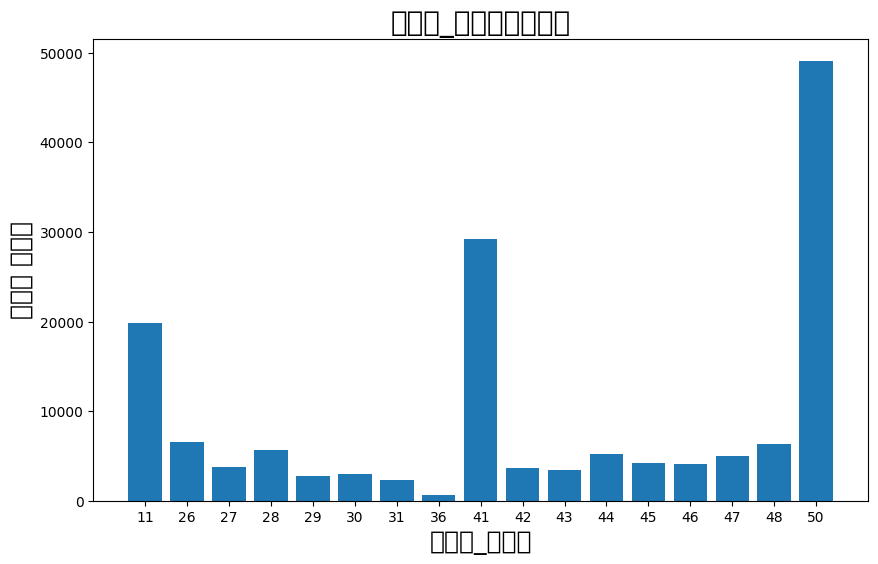

In [86]:
x1 = 수하인_시운송장총건수.index
y1 = 수하인_시운송장총건수['운송장_건수']

plt.bar(x1, y1)
plt.title('수하인_시운송장총건수', fontsize=20)
plt.xlabel('수하인_시코드', fontsize=18)
plt.ylabel('운송장 총건수', fontsize=18)

plt.show()

> 송하인 인코딩

In [79]:
train.groupby('송하인_시코드')['운송장_건수'].sum()

송하인_시코드
11      6252
26      1214
27      1176
28      1250
29       324
30      1416
31       175
36        31
41     27198
42       724
43      1832
44      1797
45      1412
46       758
47      1502
48       953
50    106582
Name: 운송장_건수, dtype: int64

In [80]:
train['송하인_시운송장총건수']=''

In [81]:
for k in range(len(train)):
    if train['송하인_시코드'][k] == '11':
      train['송하인_시운송장총건수'][k] = 6252
    if train['송하인_시코드'][k] == '26':
      train['송하인_시운송장총건수'][k] = 1214
    if train['송하인_시코드'][k] == '27':
      train['송하인_시운송장총건수'][k] = 1176
    if train['송하인_시코드'][k] == '28':
      train['송하인_시운송장총건수'][k] = 1250
    if train['송하인_시코드'][k] == '29':
      train['송하인_시운송장총건수'][k] = 324
    if train['송하인_시코드'][k] == '30':
      train['송하인_시운송장총건수'][k] = 1416
    if train['송하인_시코드'][k] == '31':
      train['송하인_시운송장총건수'][k] = 175
    if train['송하인_시코드'][k] == '36':
      train['송하인_시운송장총건수'][k] = 31
    if train['송하인_시코드'][k] == '41':
      train['송하인_시운송장총건수'][k] = 27198
    if train['송하인_시코드'][k] == '42':
      train['송하인_시운송장총건수'][k] = 724
    if train['송하인_시코드'][k] == '43':
      train['송하인_시운송장총건수'][k] = 1832
    if train['송하인_시코드'][k] == '44':
      train['송하인_시운송장총건수'][k] = 1797
    if train['송하인_시코드'][k] == '45':
      train['송하인_시운송장총건수'][k] = 1412
    if train['송하인_시코드'][k] == '46':
      train['송하인_시운송장총건수'][k] = 758
    if train['송하인_시코드'][k] == '47':
      train['송하인_시운송장총건수'][k] = 1502
    if train['송하인_시코드'][k] == '48':
      train['송하인_시운송장총건수'][k] = 953
    if train['송하인_시코드'][k] == '50':
      train['송하인_시운송장총건수'][k] = 106582

In [82]:
train.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수,송하인_시운송장총건수
index,,,,,,,,,,,,
0,5011000595017300,2871000192069300,음반,3,50,28,110,710,00595,00192,5623,106582
1,4148000690043300,5011000264024400,문화컨텐츠,3,41,50,480,110,00690,00264,49104,27198
2,5011000078068400,1120000007005400,농산물,3,50,11,110,200,00078,00007,19852,106582
3,4127100048006400,5011000587019400,기타식품,7,41,50,271,110,00048,00587,49104,27198
4,5011000078068400,2823700010076300,농산물,3,50,28,110,237,00078,00010,5623,106582


> 송하인 운송장 건수 EDA

In [84]:
송하인_시운송장총건수 = pd.DataFrame(train.groupby('송하인_시코드')['운송장_건수'].sum())

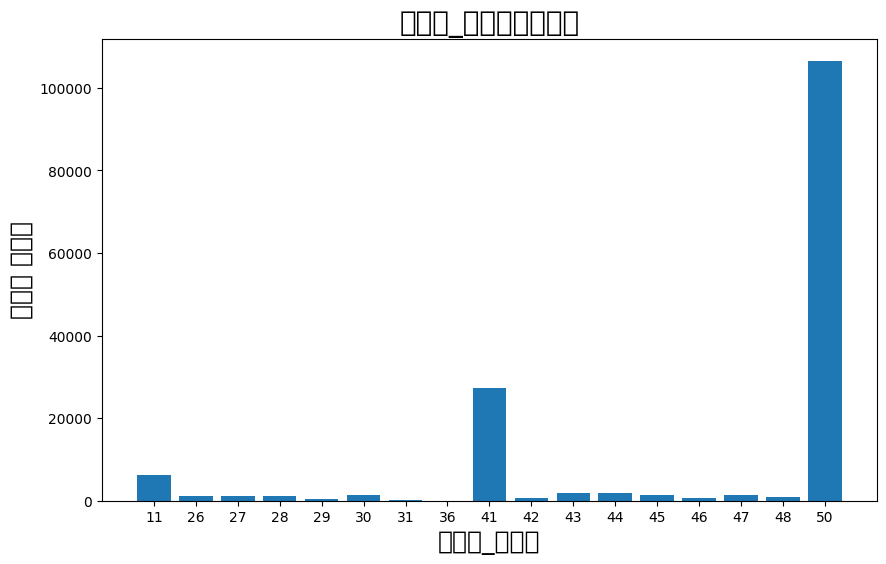

In [87]:
x2 = 송하인_시운송장총건수.index
y2 = 송하인_시운송장총건수['운송장_건수']

plt.bar(x2, y2)
plt.title('송하인_시운송장총건수', fontsize=20)
plt.xlabel('송하인_시코드', fontsize=18)
plt.ylabel('운송장 총건수', fontsize=18)

plt.show()

#### 군구/동 : 빈도로 인코딩
* train test 합쳐서 빈도 도출
* 빈도 도출한 뒤 split

In [88]:
num_train = len(train)
all_data = pd.concat([train, test], ignore_index=True)
all_data

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수,송하인_시운송장총건수
0,5011000595017300,2871000192069300,음반,3.0,50,28,110,710,00595,00192,5623,106582
1,4148000690043300,5011000264024400,문화컨텐츠,3.0,41,50,480,110,00690,00264,49104,27198
2,5011000078068400,1120000007005400,농산물,3.0,50,11,110,200,00078,00007,19852,106582
3,4127100048006400,5011000587019400,기타식품,7.0,41,50,271,110,00048,00587,49104,27198
4,5011000078068400,2823700010076300,농산물,3.0,50,28,110,237,00078,00010,5623,106582
...,...,...,...,...,...,...,...,...,...,...,...,...
39599,5011000266051200,4623000417038100,농산물,NaN,50,46,110,230,00266,00417,NaN,NaN
39600,1154500001098300,5011000264055100,문화컨텐츠,NaN,11,50,545,110,00001,00264,NaN,NaN
39601,5013000610049100,1147000018091400,농산물,NaN,50,11,130,470,00610,00018,NaN,NaN
39602,5013000610049100,3117000039026100,농산물,NaN,50,31,130,170,00610,00039,NaN,NaN


군구

In [89]:
# 송하인
freq_song_gu = all_data['송하인_군구코드'].value_counts().sort_values()
freq_song_gu = freq_song_gu.reset_index()
freq_song_gu.columns = ['군구동', '빈도']

all_data['송하인_군구코드_빈도']=0

for i in range(len(all_data)):
  for j in range(len(freq_song_gu)):
    if all_data['송하인_군구코드'][i] == freq_song_gu['군구동'][j]:
      all_data['송하인_군구코드_빈도'][i] = freq_song_gu['빈도'][j]

In [90]:
# 수하인
freq_su_gu = all_data['수하인_군구코드'].value_counts().sort_values()
freq_su_gu = freq_su_gu.reset_index()
freq_su_gu.columns = ['군구동', '빈도']

all_data['수하인_군구코드_빈도']=0

for i in range(len(all_data)):
  for j in range(len(freq_su_gu)):
    if all_data['수하인_군구코드'][i] == freq_su_gu['군구동'][j]:
      all_data['수하인_군구코드_빈도'][i] = freq_su_gu['빈도'][j]

동

In [91]:
# 송하인
freq_song_dong = all_data['송하인_동코드'].value_counts().sort_values()
freq_song_dong = freq_song_dong.reset_index()
freq_song_dong.columns = ['군구동', '빈도']

all_data['송하인_동코드_빈도']=0

for i in range(len(all_data)):
  for j in range(len(freq_song_dong)):
    if all_data['송하인_동코드'][i] == freq_song_dong['군구동'][j]:
      all_data['송하인_동코드_빈도'][i] = freq_song_dong['빈도'][j]

In [92]:
# 수하인
freq_su_dong = all_data['수하인_동코드'].value_counts().sort_values()
freq_su_dong = freq_su_dong.reset_index()
freq_su_dong.columns = ['군구동', '빈도']

all_data['수하인_동코드_빈도']=0

for i in range(len(all_data)):
  for j in range(len(freq_su_dong)):
    if all_data['수하인_동코드'][i] == freq_su_dong['군구동'][j]:
      all_data['수하인_동코드_빈도'][i] = freq_su_dong['빈도'][j]

In [93]:
train = all_data.iloc[0:num_train+1, :]
test = all_data.iloc[num_train:, :]
test.drop(['운송장_건수'], axis=1, inplace=True)

In [98]:
train.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수,송하인_시운송장총건수,송하인_군구코드_빈도,수하인_군구코드_빈도,송하인_동코드_빈도,수하인_동코드_빈도
0,5011000595017300,2871000192069300,음반,3.0,50,28,110,710,00595,00192,5623,106582,16407,1019,589,31
1,4148000690043300,5011000264024400,문화컨텐츠,3.0,41,50,480,110,00690,00264,49104,27198,1494,9136,881,332
2,5011000078068400,1120000007005400,농산물,3.0,50,11,110,200,00078,00007,19852,106582,16407,1437,4882,550
3,4127100048006400,5011000587019400,기타식품,7.0,41,50,271,110,00048,00587,49104,27198,54,9136,66,20
4,5011000078068400,2823700010076300,농산물,3.0,50,28,110,237,00078,00010,5623,106582,16407,241,4882,604


In [99]:
test.reset_index(drop=True, inplace=True)

In [100]:
test.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수,송하인_시운송장총건수,송하인_군구코드_빈도,수하인_군구코드_빈도,송하인_동코드_빈도,수하인_동코드_빈도
0,4167000577042200,5011000435014100,선케어,41,50,670,110,00577,00435,NaN,NaN,31,9136,6,186
1,1156000009012200,5011000172034400,구강위생용품,11,50,560,110,00009,00172,NaN,NaN,66,9136,371,117
2,4122000363057300,5011000361097300,캠핑,41,50,220,110,00363,00361,NaN,NaN,162,9136,26,28
3,5011000436041400,2826000084036400,아웃도어가구,50,28,110,260,00436,00084,NaN,NaN,16407,828,66,49
4,4150000241065200,5011000169044300,분유/이유식/아기간식,41,50,500,110,00241,00169,NaN,NaN,505,9136,106,71


> 군구 빈도 EDA

In [103]:
all_data['수하인_군구코드_빈도'].nunique()

94

In [105]:
all_data['송하인_군구코드_빈도'].nunique()

73

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

d1 = all_data['수하인_군구코드_빈도']
sns.boxplot(d1)
ax1.text(50,16, "TOTAL count: {}".format(d1.count()))
ax1.text(50,15, "Mean Frequency: {:.1f}".format(d1.mean()))
ax1.text(50,14, "Median Frequency: {:.1f}".format(d1.median()))
ax1.text(50,13, "Std. deviation Frequency: {:.1f}".format(d1.std()))
ax1.set_title('수하인_군구코드_빈도')

d2 = all_data['송하인_군구코드_빈도']
sns.boxplot(d2)
ax2.text(50,16, "TOTAL count: {}".format(d2.count()))
ax2.text(50,15, "Mean Frequency: {:.1f}".format(d2.mean()))
ax2.text(50,14, "Median Frequency: {:.1f}".format(d2.median()))
ax2.text(50,13, "Std. deviation Frequency: {:.1f}".format(d2.std()))
ax2.set_title('송하인_군구코드_빈도')

plt.show()

> 송하인 빈도 EDA

In [104]:
all_data['수하인_동코드_빈도'].nunique()

153

In [106]:
all_data['송하인_동코드_빈도'].nunique()

147

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

d3 = all_data['수하인_동코드_빈도']
sns.boxplot(d3)
ax1.text(50,16, "TOTAL count: {}".format(d3.count()))
ax1.text(50,15, "Mean Frequency: {:.1f}".format(d3.mean()))
ax1.text(50,14, "Median Frequency: {:.1f}".format(d3.median()))
ax1.text(50,13, "Std. deviation Frequency: {:.1f}".format(d3.std()))
ax1.set_title('수하인_동코드_빈도')

d4 = all_data['송하인_동코드_빈도']
sns.boxplot(d4)
ax2.text(50,16, "TOTAL count: {}".format(d4.count()))
ax2.text(50,15, "Mean Frequency: {:.1f}".format(d4.mean()))
ax2.text(50,14, "Median Frequency: {:.1f}".format(d4.median()))
ax2.text(50,13, "Std. deviation Frequency: {:.1f}".format(d4.std()))
ax2.set_title('송하인_동코드_빈도')

plt.show()

## 2) 물품_카테고리

In [ ]:
pd.set_option('display.max_rows', None)
print(train.iloc[:,3].value_counts())

### (1) 물품_카테고리_대분류 열 생성

In [133]:
식품 = ['농산물', '기타식품', '수산', '건강식품', '음료', '가공식품', '축산', '과자', '다이어트식품', '냉동/간편조리식품', '김치','반찬']
생활건강 = ['의료용품','건강용품', '생활용품', '주방용품', '위생/건강용품', '재활운동용품', '자동차용품' ,
            '수납/정리용품', '취미용품', '구강위생용품', '눈관리용품', '욕실용품', '세탁용품', '공구', '문구/사무용품']
스포츠레저 = ['기타스포츠/레저' ,'등산', '낚시', '골프' ,'캠핑' ,'헬스' ]
가구인테리어 = ['서재/사무용가구', '주방가구', '침실가구' ,'수납가구' ,'아웃도어가구' ,'유아가구' ,
                 '침구세트', '침구단품', '인테리어소품', '커튼/블라인드', 'DIY자재/용품', '홈데코', '카페트/러그']
도서음반 = ['음반', '문화컨텐츠']
패션잡화 = ['선글라스/안경테', '양말/스타킹', '가방', '주얼리' ,'패션소품', '모자' ,'기타패션잡화' ,'지갑', '헤어액세서리']
패션의류 = ['아우터', '신발', '상의', '하의', '기타패션의류', '잠옷', '언더웨어' ,'원피스/점프슈트', '기능성']
기타 = ['반려동물']
출산육아 = ['기저귀/물티슈', '기타출산/육아', '분유/이유식/아기간식', '출산/유아동잡화', '출산/유아동의류', '완구/매트']
디지털가전 = ['모니터', 'PC' ,'PC주변기기', '게임기/타이틀', '스마트디바이스액세서리', '태블릿PC/노트북액세서리', 
               '스마트디바이스', '기타디지털/가전' ,'주방가전', '음향가전', '계절가전' ,'생활가전' ,'이미용가전']
화장품미용 = ['스킨케어', '헤어케어', '바디케어', '선케어', '네일케어', '기타화장품/미용' ,
               '색조메이크업', '클렌징' ,'헤어스타일링', '뷰티소품', '남성화장품' ,'베이스메이크업', '향수']

In [134]:
train['물품_카테고리_대분류']=' '

In [135]:
for i in train['물품_카테고리']:
  if i in 식품:
    train.loc[train['물품_카테고리']==i, '물품_카테고리_대분류'] = '식품'
  elif i in 생활건강:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='생활건강'
  elif i in 스포츠레저:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='스포츠레저'
  elif i in 가구인테리어:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='가구인테리어'
  elif i in 도서음반:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='도서음반'
  elif i in 패션잡화:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='패션잡화'
  elif i in 패션의류:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='패션의류'
  elif i in 기타:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='기타'
  elif i in 출산육아:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='출산육아'
  elif i in 디지털가전:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='디지털가전'
  else:
    train.loc[train['물품_카테고리']==i,'물품_카테고리_대분류']='화장품미용'

In [136]:
train.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수,송하인_시운송장총건수,송하인_군구코드_빈도,수하인_군구코드_빈도,송하인_동코드_빈도,수하인_동코드_빈도,물품_카테고리_대분류
0,5011000595017300,2871000192069300,음반,3.0,50,28,110,710,00595,00192,5623,106582,16407,1019,589,31,도서음반
1,4148000690043300,5011000264024400,문화컨텐츠,3.0,41,50,480,110,00690,00264,49104,27198,1494,9136,881,332,도서음반
2,5011000078068400,1120000007005400,농산물,3.0,50,11,110,200,00078,00007,19852,106582,16407,1437,4882,550,식품
3,4127100048006400,5011000587019400,기타식품,7.0,41,50,271,110,00048,00587,49104,27198,54,9136,66,20,식품
4,5011000078068400,2823700010076300,농산물,3.0,50,28,110,237,00078,00010,5623,106582,16407,241,4882,604,식품


In [137]:
test['물품_카테고리_대분류']=' '

In [138]:
for i in test['물품_카테고리']:
  if i in 식품:
    test.loc[test['물품_카테고리']==i, '물품_카테고리_대분류'] = '식품'
  elif i in 생활건강:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='생활건강'
  elif i in 스포츠레저:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='스포츠레저'
  elif i in 가구인테리어:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='가구인테리어'
  elif i in 도서음반:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='도서음반'
  elif i in 패션잡화:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='패션잡화'
  elif i in 패션의류:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='패션의류'
  elif i in 기타:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='기타'
  elif i in 출산육아:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='출산육아'
  elif i in 디지털가전:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='디지털가전'
  else:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='화장품미용'

In [139]:
test.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수,송하인_시운송장총건수,송하인_군구코드_빈도,수하인_군구코드_빈도,송하인_동코드_빈도,수하인_동코드_빈도,물품_카테고리_대분류
0,4167000577042200,5011000435014100,선케어,41,50,670,110,00577,00435,NaN,NaN,31,9136,6,186,화장품미용
1,1156000009012200,5011000172034400,구강위생용품,11,50,560,110,00009,00172,NaN,NaN,66,9136,371,117,생활건강
2,4122000363057300,5011000361097300,캠핑,41,50,220,110,00363,00361,NaN,NaN,162,9136,26,28,스포츠레저
3,5011000436041400,2826000084036400,아웃도어가구,50,28,110,260,00436,00084,NaN,NaN,16407,828,66,49,가구인테리어
4,4150000241065200,5011000169044300,분유/이유식/아기간식,41,50,500,110,00241,00169,NaN,NaN,505,9136,106,71,출산육아


### (2) 물품_카테고리_대분류 인코딩
* 운송장_건수 합으로 인코딩

In [140]:
train.groupby('물품_카테고리_대분류')['운송장_건수'].sum()

물품_카테고리_대분류
가구인테리어      1586.0
기타          1388.0
도서음반        7786.0
디지털가전       2908.0
생활건강        8819.0
스포츠레저        839.0
식품        119921.0
출산육아        1104.0
패션의류        6299.0
패션잡화         515.0
화장품미용       3431.0
Name: 운송장_건수, dtype: float64

In [141]:
train['물품_대분류_운송장총건수']=''

In [142]:
for k in range(len(train)):
    if train['물품_카테고리_대분류'][k] == '가구인테리어':
      train['물품_대분류_운송장총건수'][k] = 1586
    if train['물품_카테고리_대분류'][k] == '기타':
      train['물품_대분류_운송장총건수'][k] = 1388
    if train['물품_카테고리_대분류'][k] == '도서음반':
      train['물품_대분류_운송장총건수'][k] = 7786
    if train['물품_카테고리_대분류'][k] == '디지털가전':
      train['물품_대분류_운송장총건수'][k] = 2908
    if train['물품_카테고리_대분류'][k] == '생활건강':
      train['물품_대분류_운송장총건수'][k] = 8819
    if train['물품_카테고리_대분류'][k] == '스포츠레저':
      train['물품_대분류_운송장총건수'][k] = 839
    if train['물품_카테고리_대분류'][k] == '식품':
      train['물품_대분류_운송장총건수'][k] = 119921
    if train['물품_카테고리_대분류'][k] == '출산육아':
      train['물품_대분류_운송장총건수'][k] = 1104
    if train['물품_카테고리_대분류'][k] == '패션의류':
      train['물품_대분류_운송장총건수'][k] = 6299
    if train['물품_카테고리_대분류'][k] == '패션잡화':
      train['물품_대분류_운송장총건수'][k] = 515
    if train['물품_카테고리_대분류'][k] == '화장품미용':
      train['물품_대분류_운송장총건수'][k] = 3431

In [143]:
train.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수,송하인_시운송장총건수,송하인_군구코드_빈도,수하인_군구코드_빈도,송하인_동코드_빈도,수하인_동코드_빈도,물품_카테고리_대분류,물품_대분류_운송장총건수
0,5011000595017300,2871000192069300,음반,3.0,50,28,110,710,00595,00192,5623,106582,16407,1019,589,31,도서음반,7786
1,4148000690043300,5011000264024400,문화컨텐츠,3.0,41,50,480,110,00690,00264,49104,27198,1494,9136,881,332,도서음반,7786
2,5011000078068400,1120000007005400,농산물,3.0,50,11,110,200,00078,00007,19852,106582,16407,1437,4882,550,식품,119921
3,4127100048006400,5011000587019400,기타식품,7.0,41,50,271,110,00048,00587,49104,27198,54,9136,66,20,식품,119921
4,5011000078068400,2823700010076300,농산물,3.0,50,28,110,237,00078,00010,5623,106582,16407,241,4882,604,식품,119921


### (3) 물품_카테고리_대분류 생성 전후 비교

In [145]:
물품_운송장총건수 = pd.DataFrame(train.groupby('물품_카테고리')['운송장_건수'].sum())

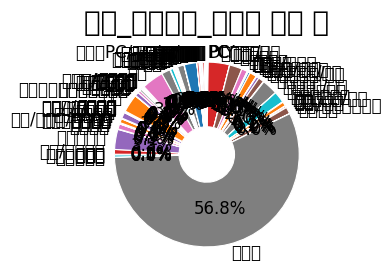

In [152]:
ratio1 = 물품_운송장총건수['운송장_건수']
labels1 = 물품_운송장총건수.index
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 0.8}

plt.pie(ratio1, labels=labels1, autopct='%.1f%%', startangle=90, counterclock=False, wedgeprops=wedgeprops)
plt.title('물품_카테고리_대분류 생성 전', fontsize=20)

plt.show()

In [153]:
물품_대분류_운송장총건수 = pd.DataFrame(train.groupby('물품_카테고리_대분류')['운송장_건수'].sum())

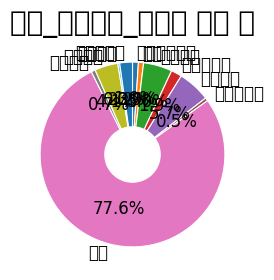

In [154]:
ratio2 = 물품_대분류_운송장총건수['운송장_건수']
labels2 = 물품_대분류_운송장총건수.index
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 0.8}

plt.pie(ratio2, labels=labels2, autopct='%.1f%%', startangle=90, counterclock=False, wedgeprops=wedgeprops)
plt.title('물품_카테고리_대분류 생성 후', fontsize=20)

plt.show()

## 3) test 인코딩

#### 시군구 : train의 총운송장건수로 인코딩

In [155]:
a = train['수하인_시코드']
a.head()
a = list(a)

# a를 먼저 나온 unique한 값 순서 맞춰 남기기 위해 처리
a_unique = list(dict.fromkeys(a))
a_unique

b = train['수하인_시운송장총건수']
b.head()
b = list(b)

# b를 먼저 나온 unique한 값 순서 맞춰 남기기 위해 처리
b_unique = list(dict.fromkeys(b))
b_unique

test['수하인_시운송장총건수'] = 0
test.head()

l=0

for i in a_unique: # a에 있는 시번호와 매칭해볼 예정
  for k in range(len(test)): 
    if test['수하인_시코드'][k] == i:
      test['수하인_시운송장총건수'][k] = b_unique[l]
  l=l+1

In [156]:
df3 = train.groupby('송하인_시코드')['운송장_건수'].sum()

test['송하인_시운송장총건수'] = ''

for i in range(len(test)):
  for j in range(len(df3)):
    if test['송하인_시코드'][i] == df3.index[j]:
      test['송하인_시운송장총건수'][i] = df3[j]

In [157]:
test.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수,송하인_시운송장총건수,송하인_군구코드_빈도,수하인_군구코드_빈도,송하인_동코드_빈도,수하인_동코드_빈도,물품_카테고리_대분류
0,4167000577042200,5011000435014100,선케어,41,50,670,110,00577,00435,49104,27198.0,31,9136,6,186,화장품미용
1,1156000009012200,5011000172034400,구강위생용품,11,50,560,110,00009,00172,49104,6252.0,66,9136,371,117,생활건강
2,4122000363057300,5011000361097300,캠핑,41,50,220,110,00363,00361,49104,27198.0,162,9136,26,28,스포츠레저
3,5011000436041400,2826000084036400,아웃도어가구,50,28,110,260,00436,00084,5623,106582.0,16407,828,66,49,가구인테리어
4,4150000241065200,5011000169044300,분유/이유식/아기간식,41,50,500,110,00241,00169,49104,27198.0,505,9136,106,71,출산육아


#### 물품 : train의 대분류 총운송장건수로 인코딩

In [158]:
test['물품_카테고리_대분류']=' '

In [159]:
for i in test['물품_카테고리']:
  if i in 식품:
    test.loc[test['물품_카테고리']==i, '물품_카테고리_대분류'] = '식품'
  elif i in 생활건강:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='생활건강'
  elif i in 스포츠레저:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='스포츠레저'
  elif i in 가구인테리어:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='가구인테리어'
  elif i in 도서음반:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='도서음반'
  elif i in 패션잡화:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='패션잡화'
  elif i in 패션의류:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='패션의류'
  elif i in 기타:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='기타'
  elif i in 출산육아:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='출산육아'
  elif i in 디지털가전:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='디지털가전'
  else:
    test.loc[test['물품_카테고리']==i,'물품_카테고리_대분류']='화장품미용'

In [161]:
df1 = train.groupby('물품_카테고리_대분류')['운송장_건수'].sum()

test['물품_대분류_운송장총건수'] = ''

for i in range(len(test)):
  for j in range(len(df1)):
    if test['물품_카테고리_대분류'][i] == df1.index[j]:
      test['물품_대분류_운송장총건수'][i] = df1[j]

In [162]:
test.head()

,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,송하인_시코드,수하인_시코드,송하인_군구코드,수하인_군구코드,송하인_동코드,수하인_동코드,수하인_시운송장총건수,송하인_시운송장총건수,송하인_군구코드_빈도,수하인_군구코드_빈도,송하인_동코드_빈도,수하인_동코드_빈도,물품_카테고리_대분류,물품_대분류_운송장총건수
0,4167000577042200,5011000435014100,선케어,41,50,670,110,00577,00435,49104,27198.0,31,9136,6,186,화장품미용,3431.0
1,1156000009012200,5011000172034400,구강위생용품,11,50,560,110,00009,00172,49104,6252.0,66,9136,371,117,생활건강,8819.0
2,4122000363057300,5011000361097300,캠핑,41,50,220,110,00363,00361,49104,27198.0,162,9136,26,28,스포츠레저,839.0
3,5011000436041400,2826000084036400,아웃도어가구,50,28,110,260,00436,00084,5623,106582.0,16407,828,66,49,가구인테리어,1586.0
4,4150000241065200,5011000169044300,분유/이유식/아기간식,41,50,500,110,00241,00169,49104,27198.0,505,9136,106,71,출산육아,1104.0


## 4) 변수 정리

In [163]:
train.drop(['송하인_격자공간고유번호','수하인_격자공간고유번호','물품_카테고리','물품_카테고리_대분류',
            '송하인_시코드','수하인_시코드','송하인_군구코드','수하인_군구코드','송하인_동코드','수하인_동코드'], axis=1, inplace=True)
test.drop(['송하인_격자공간고유번호','수하인_격자공간고유번호','물품_카테고리','물품_카테고리_대분류',
            '송하인_시코드','수하인_시코드','송하인_군구코드','수하인_군구코드','송하인_동코드','수하인_동코드'], axis=1, inplace=True)

In [164]:
train = pd.read_csv('train_code.csv')
test = pd.read_csv('test_code.csv')

submission = pd.read_csv('sample_submission.csv')

In [ ]:
train.head()

In [ ]:
test.head()

In [165]:
from sklearn.model_selection import train_test_split

X_features = train.drop(['운송장_건수'], axis=1)
y_labels = train['운송장_건수']
X_train, X_tr_test, y_train, y_tr_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)

In [166]:
print(X_train.shape, y_train.shape, X_tr_test.shape, y_tr_test.shape)

(25347, 7) (25347,) (6337, 7) (6337,)


In [ ]:
train.head()

In [ ]:
test.head()

## 5) 스케일링

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
rbs = RobustScaler()
rbs.fit(X_train)

In [ ]:
X_train_scaled0 = rbs.transform(X_train)
X_tr_test_scaled0 = rbs.transform(X_tr_test)
test_scaled0 = rbs.transform(test)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled0)
X_train_scaled.columns = train.columns[1:]

X_tr_test_scaled = pd.DataFrame(X_tr_test_scaled0)
X_tr_test_scaled.columns = train.columns[1:]

test_scaled = pd.DataFrame(test_scaled0)
test_scaled.columns = test.columns

In [ ]:
X_train_scaled.head()

# 04 모델링

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

#### (1) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#모델 정의
model_rf = RandomForestRegressor()

# 모델 학습
model_rf.fit(X_train_scaled, y_train)

# test 데이터 예측
y_pred_rf = model_rf.predict(X_tr_test_scaled)

In [ ]:
# RMSE 확인
MSE_rf = mean_squared_error(y_tr_test, y_pred_rf) 
np.sqrt(MSE_rf)

6.672102454652059

In [ ]:
# 랜덤서치 파라미터 튜닝

from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params = {'max_depth': range(2, 21, 2),
              'min_samples_split': range(5, 21, 5),
              'min_samples_leaf' : range(5, 21, 5),
              'n_estimators': range(50, 251, 50),
              'random_state': range(100, 2000, 200)
}

model_rf_rd_rs = RandomizedSearchCV(model_rf, param_distributions=params, n_iter=50, cv=4, n_jobs=-1)

model_rf_rd_rs.fit(X_train_scaled, y_train)
y_pred_rf_rd_rs = model_rf_rd_rs.best_estimator_.predict(X_tr_test_scaled)

MSE_rf_rd_rs = mean_squared_error(y_tr_test, y_pred_rf_rd_rs) 
np.sqrt(MSE_rf_rd_rs)

6.400724053322976

In [ ]:
model_rf_rd_rs.best_estimator_

RandomForestRegressor(max_depth=8, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=150, random_state=700)

In [ ]:
rf_best = RandomForestRegressor(max_depth=8, min_samples_leaf=5, 
                                    min_samples_split=5, n_estimators=150, 
                                    random_state=700)

#### (2) GBM

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

#모델 정의
model_gbm = GradientBoostingRegressor()

# 모델 학습
model_gbm.fit(X_train_scaled, y_train)

# test 데이터 예측
y_pred_gbm = model_gbm.predict(X_tr_test_scaled)

In [ ]:
# RMSE 확인
MSE_gbm = mean_squared_error(y_tr_test, y_pred_gbm) 
np.sqrt(MSE_gbm)

6.408173807127041

In [ ]:
from random import * 
from numpy import random

In [ ]:
# 파라미터 튜닝
params = {'max_depth': range(2, 21, 2),
          'min_samples_leaf' :range(5,21,5),
          'min_samples_split': range(5,21,5),
          'n_estimators': range(50, 251, 50), 
          'learning_rate': random.uniform(0.02, 0.1, 5),
          'random_state': range(100, 2001, 200)         
}

model_gbm_rd = RandomizedSearchCV(model_gbm, param_distributions=params, n_iter=50, cv=4, n_jobs=-1)

model_gbm_rd.fit(X_train_scaled, y_train)
y_pred_gbm_rd = model_gbm_rd.best_estimator_.predict(X_tr_test_scaled)

MSE_gbm_rd = mean_squared_error(y_tr_test, y_pred_gbm_rd) 
np.sqrt(MSE_gbm_rd)

6.360792670707317

In [ ]:
model_gbm_rd.best_estimator_

GradientBoostingRegressor(learning_rate=0.046080080441062786, max_depth=4,
                          min_samples_leaf=5, min_samples_split=10,
                          n_estimators=200, random_state=900)

In [ ]:
gbm_best = GradientBoostingRegressor(learning_rate=0.046, max_depth=4,
                                     min_samples_leaf=5, min_samples_split=10,
                                     n_estimators=200, random_state=900)

#### (3) LGBM

In [ ]:
from lightgbm import LGBMRegressor

#모델 정의
model_lgbm = LGBMRegressor()

# 모델 학습
model_lgbm.fit(X_train_scaled, y_train)

# test 데이터 예측
y_pred_lgbm = model_lgbm.predict(X_tr_test_scaled)

In [ ]:
# RMSE 확인
MSE_lgbm = mean_squared_error(y_tr_test, y_pred_lgbm) 
np.sqrt(MSE_lgbm)

6.4104618094844215

In [ ]:
# 파라미터 튜닝
params = {'max_depth': range(2, 21, 2),
          'num_leaves': range(100, 201, 20),
          'learning_rate': random.uniform(0.02, 0.1, 5),
          'random_state': range(100, 2001, 200)          
}

model_lgbm_rd = RandomizedSearchCV(model_lgbm, param_distributions=params, n_iter=50, cv=4, n_jobs=-1)

model_lgbm_rd.fit(X_train_scaled, y_train)
y_pred_lgbm_rd = model_lgbm_rd.best_estimator_.predict(X_tr_test_scaled)

MSE_lgbm_rd = mean_squared_error(y_tr_test, y_pred_lgbm_rd) 
np.sqrt(MSE_lgbm_rd)

6.4004705130959785

In [ ]:
model_lgbm_rd.best_estimator_

LGBMRegressor(learning_rate=0.07016757608427318, max_depth=6, num_leaves=160,
              random_state=900)

In [ ]:
lgbm_best = LGBMRegressor(learning_rate=0.07, max_depth=6, 
                          num_leaves=160,random_state=900)

#### (4) XGBoost

In [ ]:
from xgboost import XGBRegressor

#모델 정의
model_xgb = XGBRegressor()

# 모델 학습
model_xgb.fit(X_train_scaled, y_train)

# test 데이터 예측
y_pred_xgb = model_xgb.predict(X_tr_test_scaled)

In [ ]:
# RMSE 확인
MSE_xgb = mean_squared_error(y_tr_test, y_pred_xgb) 
np.sqrt(MSE_xgb)

6.466819792344258

In [ ]:
# 파라미터 튜닝
params = {'max_depth': range(2, 21, 2),
          'subsample': random.uniform(0.4, 1, 5),
          'n_estimators': range(50, 251, 50), 
          'learning_rate': random.uniform(0.02, 0.1, 5),
          'random_state': range(100, 2001, 200)          
}

model_xgb_rd = RandomizedSearchCV(model_xgb, param_distributions=params, n_iter=50, cv=4, n_jobs=-1)

model_xgb_rd.fit(X_train_scaled, y_train)
y_pred_xgb_rd = model_xgb_rd.best_estimator_.predict(X_tr_test_scaled)

MSE_xgb_rd = mean_squared_error(y_tr_test, y_pred_xgb_rd) 
np.sqrt(MSE_xgb_rd)

6.374139598831045

In [ ]:
model_xgb_rd.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04934527950305575,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=100, ...)

In [ ]:
model_xgb_rd.best_estimator_.subsample

0.7054787222367651

In [ ]:
xgb_best = XGBRegressor(learning_rate=0.05, max_depth=4, subsample=0.7,
                        n_estimators=100, random_state=100)

### 앙상블

#### (1) 소프트맥스

In [ ]:
y_pred_soft = 0.4*y_pred_gbm_rd + 0.3*y_pred_xgb_rd + 0.2*y_pred_lgbm_rd + 0.1*y_pred_rf_rd_rs

MSE_soft = mean_squared_error(y_tr_test, y_pred_soft) 
np.sqrt(MSE_soft)

6.359231890245019

## 정답파일 생성

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,index,운송장_건수
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
y_pred_rf_rd_rs = model_rf_rd_rs.best_estimator_.predict(test_scaled)
y_pred_gbm_rd = model_gbm_rd.best_estimator_.predict(test_scaled)
y_pred_lgbm_rd = model_lgbm_rd.best_estimator_.predict(test_scaled)
y_pred_xgb_rd = model_xgb_rd.best_estimator_.predict(test_scaled)

y_pred_soft = 0.1*y_pred_gbm_rd + 0.2*y_pred_xgb_rd + 0.2*y_pred_lgbm_rd + 0.5*y_pred_rf_rd_rs

submission['운송장_건수'] = y_pred_soft
submission.to_csv('/content/drive/MyDrive/ESAA/OB프로젝트/sub_soft3.csv',index = False, encoding="utf-8-sig")

In [ ]:
submission['운송장_건수'] = lr_final_pred 
submission.to_csv('/content/drive/MyDrive/ESAA/OB프로젝트/sub_st_lr.csv',index = False, encoding="utf-8-sig")

In [ ]:
submission['운송장_건수'] = lr_final_pred 
submission.to_csv('/content/drive/MyDrive/ESAA/OB프로젝트/sub_st_dt.csv',index = False, encoding="utf-8-sig")

In [ ]:
y_pred_rf_rd = model_rf_rd.best_estimator_.predict(test)
submission['운송장_건수'] = y_pred_rf_rd
submission.to_csv('/content/drive/MyDrive/ESAA/OB프로젝트/sub_rf_rd.csv',index = False, encoding="utf-8-sig")

In [ ]:
# 29일날 제출해보기
y_pred_rf_rd_rs = model_rf_rd_rs.best_estimator_.predict(test)
submission['운송장_건수'] = y_pred_rf_rd_rs
submission.to_csv('/content/drive/MyDrive/ESAA/OB프로젝트/sub_rf_rd_rs.csv',index = False, encoding="utf-8-sig")

In [ ]:
y_pred_gbm_rd_sc = model_gbm_rd.best_estimator_.predict(test_scaled)
submission['운송장_건수'] = y_pred_gbm_rd_sc
submission.to_csv('/content/drive/MyDrive/ESAA/OB프로젝트/sub_gbm_rd_sc.csv',index = False, encoding="utf-8-sig")

In [ ]:
y_pred_lgbm_rd_sc = model_lgbm_rd.best_estimator_.predict(test_scaled)
submission['운송장_건수'] = y_pred_lgbm_rd_sc
submission.to_csv('/content/drive/MyDrive/ESAA/OB프로젝트/sub_lgbm_rd_sc.csv',index = False, encoding="utf-8-sig")

In [ ]:
y_pred_xgb_rd_sc = model_xgb_rd.best_estimator_.predict(test_scaled)
submission['운송장_건수'] = y_pred_xgb_rd_sc
submission.to_csv('/content/drive/MyDrive/ESAA/OB프로젝트/sub_xgb_rd_sc.csv',index = False, encoding="utf-8-sig")